In [18]:
# Import functions
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import imread, resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST, circle
from functools import cmp_to_key
from matplotlib.pyplot import imshow

## Helper functions related to multiresolution pyramids

In [5]:
#Generate base image from input image by upsampling by 2 in both directions and blurring
def generateBaseImage(image, sigma, assumed_blur):    
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    return GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)

#Compute number of octaves in image pyramid as function of base image shape
def computeNumberOfOctaves(image_shape):
    return int(round(log(min(image_shape)) / log(2) - 1))

#Generate list of gaussian kernels at which to blur the input image
def generateGaussianKernels(sigma, num_intervals):
    num_images_per_octave = num_intervals + 3
    k = 2 ** (1. / num_intervals)
    # scale of Gaussian blur used to go from one blur scale to the next within an octave
    gaussian_kernels = zeros(num_images_per_octave)  
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

#Generate scale-space pyramid of Gaussian images
def generateGaussianImages(image, num_octaves, gaussian_kernels):
    gaussian_images = []

    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            image = GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    return array(gaussian_images, dtype=object)

#Generate Difference-of-Gaussians image pyramid
def generateDoGImages(gaussian_images):
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(subtract(np.float32(second_image), np.float32(first_image)))
        dog_images.append(dog_images_in_octave)
    return array(dog_images, dtype=object)

## Helper functions related to scale-space extrema

In [11]:
#Find pixel positions of all scale-space extrema in the image pyramid
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255) 
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        keypoint = KeyPoint()
                        keypoint.pt = (j * (2 ** octave_index), i * (2 ** octave_index))
                        keypoints.append(keypoint)
    return keypoints

#Return True if the center element of the 3x3x3 input array is strictly greater than or less than all its neighbors, False otherwise
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    center_pixel_value = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return all(center_pixel_value >= first_subimage) and \
                   all(center_pixel_value >= third_subimage) and \
                   all(center_pixel_value >= second_subimage[0, :]) and \
                   all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return all(center_pixel_value <= first_subimage) and \
                   all(center_pixel_value <= third_subimage) and \
                   all(center_pixel_value <= second_subimage[0, :]) and \
                   all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False

#Convert keypoint point, size, and octave to input image size
def convertKeypointsToInputImageSize(keypoints):
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints

# Main procedure

In [17]:
image = imread('box.png',0)
sigma=1.6 
num_intervals=3 
assumed_blur=0.5 
image_border_width=5

image = image.astype('float32')

#Generate base image
base_image = generateBaseImage(image, sigma, assumed_blur)

#Compute number of octaves in the pyramid
num_octaves = computeNumberOfOctaves(base_image.shape)

#Generating Gaussian kernels and obtaining the Scale-Space Pyramid
gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)

#Obtain Difference-of-Gaussian Pyramid
dog_images = generateDoGImages(gaussian_images)

#Finding Scale-Space Extrema
keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)

#Converting keypoint indices to plot on the original image
keypoints = convertKeypointsToInputImageSize(keypoints)

## Plot input image

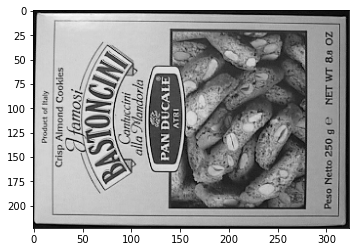

In [22]:
imshow(image, cmap='gray')

## Plot base image

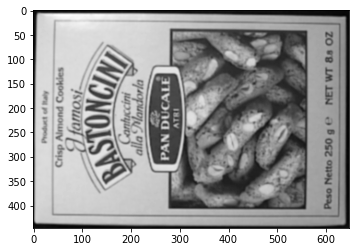

In [23]:
imshow(base_image, cmap='gray')

## Observing Scale-Spaces of 2nd octave

Text(0.5, 1.0, 'Scale = k⁵σ')

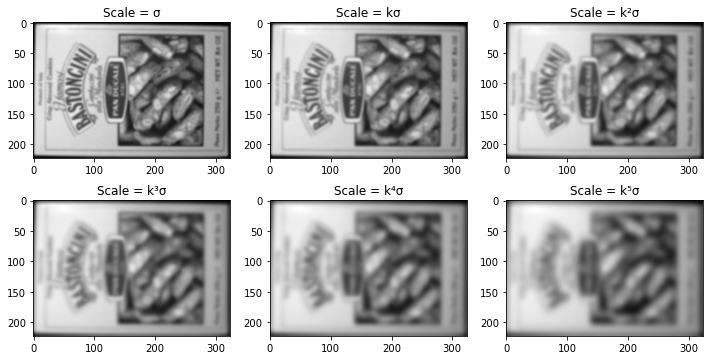

In [28]:
plt.figure(figsize=(12,6))
plt.subplot(231)
plt.imshow(gaussian_images[1][0], cmap='gray')
plt.title('Scale = \u03C3')
plt.subplot(232)
plt.imshow(gaussian_images[1][1], cmap='gray')
plt.title('Scale = k\u03C3')
plt.subplot(233)
plt.imshow(gaussian_images[1][2], cmap='gray')
plt.title('Scale = k\u00b2\u03C3')
plt.subplot(234)
plt.imshow(gaussian_images[1][3], cmap='gray')
plt.title('Scale = k\u00b3\u03C3')
plt.subplot(235)
plt.imshow(gaussian_images[1][4], cmap='gray')
plt.title('Scale = k\u2074\u03C3')
plt.subplot(236)
plt.imshow(gaussian_images[1][5], cmap='gray')
plt.title('Scale = k\u2075\u03C3')

## Observe Difference-of-Gaussian outputs of 2nd octave

Text(0.5, 1.0, 'DoG 5')

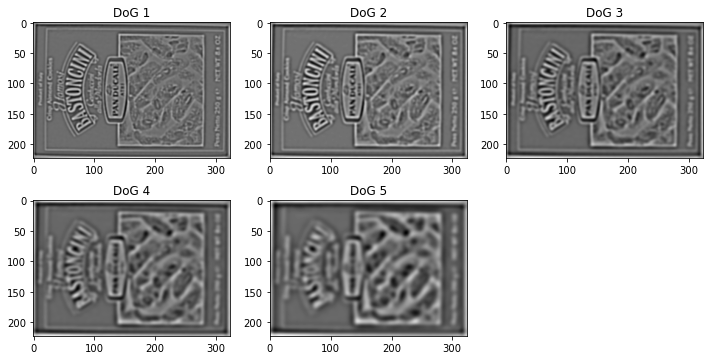

In [29]:
plt.figure(figsize=(12,6))
plt.subplot(231)
plt.imshow(dog_images[1][0], cmap='gray')
plt.title('DoG 1')
plt.subplot(232)
plt.imshow(dog_images[1][1], cmap='gray')
plt.title('DoG 2')
plt.subplot(233)
plt.imshow(dog_images[1][2], cmap='gray')
plt.title('DoG 3')
plt.subplot(234)
plt.imshow(dog_images[1][3], cmap='gray')
plt.title('DoG 4')
plt.subplot(235)
plt.imshow(dog_images[1][4], cmap='gray')
plt.title('DoG 5')

## Plotting Scale-Space Extrema on the original image

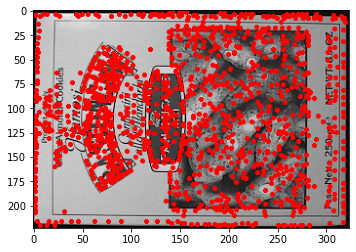

In [20]:
img = imread('box.png')
#cv2.drawKeypoints(image, keypoints, image, color=(255,0,0))
for i in range(len(keypoints)):
    circle(img, (int(round(keypoints[i].pt[0])), int(round(keypoints[i].pt[1]))), radius=1, color=(255,0,0), thickness=2)
imshow(img)